In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import netCDF4 as nc
#import xarray as xr
import scipy.ndimage
import scipy as sp
#import alphashape
from scipy import interpolate
#from shapely.geometry import Point
#from shapely.geometry.polygon import Polygon
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')


In [3]:
# Read in picked radargram data. This code assumes that the picked data is presented as
# depth below surface.

data = pd.read_csv('../Data/DataFromInka/Princess_Ragnild_Coast_airborne_IRHs_20190107_02_depth20220801_working_copy.txt', sep=" ")

# Read in BedMachine netcdf surface data 
# The surface elevation is read in as 

# Surface variable name. Change this to the surface variable name in your 
# BedMachine elevation file:
surf_name = 'zs'

ds = nc.Dataset('Derwael.nc')

# Clean up dataset: remove data not needed

data.drop(['year_acq', 'month_acq', 'day_acq', 'surveyID', 'profileID', 'lon', 'lat', 'trace', 'year_pick', 'month_pick', 'day_pick' ],axis=1, inplace=True)

# Number of picked layers:

layers = 12

# The function takes as input a depth and returns the density at that depth. The current 
# function describes the density profile of an ice core from Derwael Ice Rise. See
# doi:10.1002/2013GL058023 . Change this accordingly.

def DensityProfile(d):
    return 910.0 - 460.0 * np.exp(-0.025*d)

# Choose the output path

output_path = '../Data/AdjustedRadarStatigraphy/DepthAdjustedStratigraphyElevation.csv'

# Some column names need to be correct:
# Coordinates should take the form: 'psX', 'psY'
# Picked lines should take the form: 'IRH1', 'IRH2', etc.

# Headers in working example:
# ['psX', 'psY', 'surface', 'base', 'IRH1', 'IRH2', 'IRH3', 'IRH4', 'IRH5',
# 'IRH6', 'IRH7', 'IRH8', 'IRH9', 'IRH10', 'IRH11', 'IRH12']

# Change column names using this code if need be:
    
# data = data.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})
data

,psX,psY,surface,base,IRH1,IRH2,IRH3,IRH4,IRH5,IRH6,IRH7,IRH8,IRH9,IRH10,IRH11,IRH12
0,961154.51,1956754.7,0,178.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,961159.69,1956751.7,0,178.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,961164.87,1956748.6,0,178.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,961170.05,1956745.6,0,178.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,961175.23,1956742.5,0,179.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51197,934870.77,1950742.5,0,327.3,NaN,8.6,13.5,19.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51198,934865.73,1950745.9,0,328.0,NaN,8.9,13.2,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51199,934860.69,1950749.2,0,328.0,NaN,8.9,13.2,18.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51200,934855.64,1950752.6,0,329.8,NaN,8.9,13.2,18.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Add columns for the corresponding density due to the density profile

data['IRH0'] = [0] * len(data)
data['AdjDepthIRH0'] = [0] * len(data)

for i in range(1, layers+1):
    data['DensIRH' + str(i)] = [0] * len(data)
    
# Add columns for adjusted depth

for i in range(1, layers+1):
    data['AdjDepthIRH' + str(i)] = data['IRH' + str(i)]
    

In [5]:
# This code calculates the density adjustment. You can choose the target density and the 
# observed density profile

# Calculate the density for each point:

for i in range(1,layers+1):
    for j in range(len(data)):
        if not np.isnan(data.loc[j,'IRH' + str(i)]):
            data.loc[j,'DensIRH' + str(i)] = DensityProfile(data.loc[j,'IRH' + str(i)])

# This code calculates the equivalent depth after a density adjustment assuming a uniform
# density of 900 kg m^{-3}. These calculations allow for an adjustment where NaN values appear.
            
for i in range(1,layers+1):
    for j in range(len(data)):
        if not np.isnan(data.loc[j,'AdjDepthIRH' + str(i)]):
            k = i
            while np.isnan(data.loc[j,'AdjDepthIRH' + str(k-1)]) and k>=0:
                k = k - 1
            a0 = data.loc[j,'AdjDepthIRH' + str(i)]
            data.loc[j,'AdjDepthIRH' + str(i)] = data.loc[j,'AdjDepthIRH' + str(k-1)] \
                                             + ((data.loc[j,'AdjDepthIRH' + str(i)] \
                                               - data.loc[j,'AdjDepthIRH' + str(k-1)]) \
                                               * data.loc[j,'DensIRH' + str(i)]) / 900.0
            a1 = data.loc[j,'AdjDepthIRH' + str(i)]
            for l in range(i+1, layers+1):
                data.loc[j,'AdjDepthIRH' + str(l)] = data.loc[j,'AdjDepthIRH' + str(l)] - (a0 - a1)



In [6]:
# Remove unnecessary columns

data.drop(columns='surface', inplace=True)

for i in range(1,layers+1):
    data.drop(columns='IRH' + str(i), inplace=True)
    data.drop(columns='DensIRH' + str(i), inplace=True)


In [7]:
# Work with BedMachine netcdf surface data to allow conversion of radar stratigraphy 
# depths to elevations

surf = np.array(ds.variables[surf_name][:])
X = np.array(ds.variables['x'][:])
Y = np.array(ds.variables['y'][:])
X.shape, Y.shape
type(X)

numpy.ndarray

In [8]:
# Define the function for interpolating data from the 2D grid

data['Surface'] = np.nan * len(data)

f = interpolate.interp2d(X, Y, surf, kind='linear')

for i in range(len(data)):
    data['Surface'][i] = f(data['psX'][i], data['psY'][i])
    

/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_2997/4112046657.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Surface'][i] = f(data['psX'][i], data['psY'][i])


In [9]:
# Subtract depths from surface elevation for the stratigraphy elevation

for i in range(1,layers+1):
    data['StratElev' + str(i)]= data['Surface'] - data['AdjDepthIRH' + str(i)]


In [10]:
# Remove unnecessary columns

for i in range(0,layers+1):
    data.drop(columns='AdjDepthIRH' + str(i), inplace=True)
    

In [11]:
# Save to csv

from pathlib import Path  
filepath = Path(output_path)  
filepath.parent.mkdir(parents=True, exist_ok=True)  
data.to_csv(filepath, na_rep='NaN', index=False)


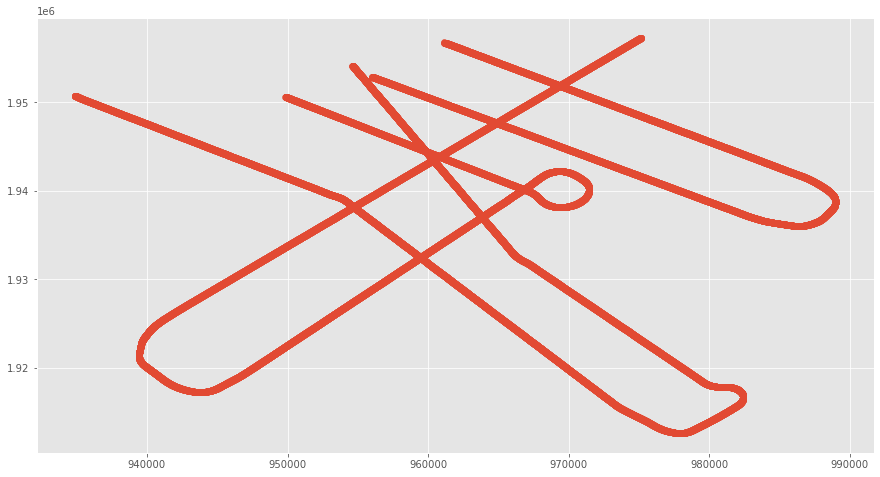

In [12]:
# Plot all coordinates

fig, ax = plt.subplots(1,1, figsize=(15, 8))
ax.scatter(data['psX'], data['psY'])
